In [1]:
import numpy as np
from sisl import *
import matplotlib.pyplot as plt
%matplotlib inline

# Berry phase calculation for graphene

This tutorial will describe a complete walk-through of how to calculate the Berry phase for graphene.

## Creating the geometry to investigate

Our system of interest will be the pristine graphene system with the on-site terms shifted by $\pm\delta$.

In [2]:
graphene = geom.graphene()
H = Hamiltonian(graphene)
H.construct([(0.1, 1.44), (0, -2.7)])

`H` now contains the pristine graphene tight-binding model. The anti-symmetric Hamiltonian is constructed like this:

In [3]:
H_bp = H.copy() # an exact copy
H_bp[0, 0] = 0.1
H_bp[1, 1] = -0.1

## Comparing electronic structures

Before proceeding to the Berry phase calculation lets compare the band structure and DOS of the two models. The anti-symmetric Hamiltonian opens a gap around the Dirac cone. A zoom on the Dirac cone shows this.

In [4]:
band = BandStructure(H, [[0, 0.5, 0], [1/3, 2/3, 0], [0.5, 0.5, 0]], 400, [r"$M$", r"$K$", r"$M'$"])

In [5]:
band.set_parent(H)
band_array = band.apply.array
bs = band_array.eigh()
band.set_parent(H_bp)
bp_bs = band_array.eigh()

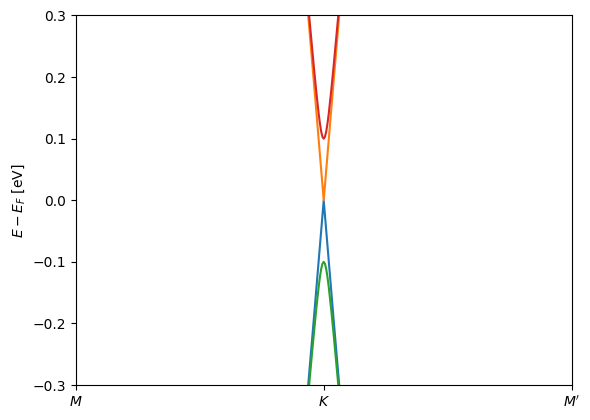

In [6]:
lk, kt, kl = band.lineark(True)
plt.xticks(kt, kl)
plt.xlim(0, lk[-1])
plt.ylim([-.3, .3])
plt.ylabel('$E-E_F$ [eV]')
for bk in bs.T:
    plt.plot(lk, bk)
for bk in bp_bs.T:
    plt.plot(lk, bk)

The gap opened is equal to the difference between the two on-site terms. In this case it equals $0.2\mathrm{eV}$. Lets, for completeness sake calculate the DOS close to the Dirac point for the two systems. To resolve the gap the distribution function (in this case the Gaussian) needs to have a small smearing value to ensure the states are not too spread and the gap smeared out.

In [7]:
bz = MonkhorstPack(H, [41, 41, 1], displacement=[1/3, 2/3, 0], size=[.125, .125, 1])
bz_average = bz.apply.average # specify the Brillouin zone to perform an average

The above `MonkhorstPack` grid initialization is creating a Monkhorst-Pack grid centered on the $K$ point with a reduced Brillouin zone size of $1/8$th of the entire Brillouin zone. Essentially this *only* calculates the DOS in a small $k$-region around the $K$-point. Since in this case we know the electronic structure of our system we can neglect all contributions from $k$-space away from the $K$-point because we are only interested in energies close to the Dirac-point.
Here the sampled $k$-points are plotted. Note how they are concentrated around $[1/3, -1/3]$ which is the $K$-point.

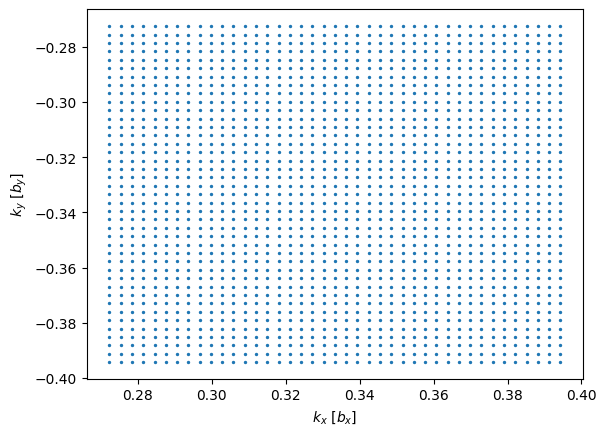

In [8]:
plt.scatter(bz.k[:, 0], bz.k[:, 1], 2);
plt.xlabel(r'$k_x$ [$b_x$]');
plt.ylabel(r'$k_y$ [$b_y$]');

Before proceeding to the Berry phase calculation we calculate the DOS in an energy region around the Dirac-point to confirm the band-gap.

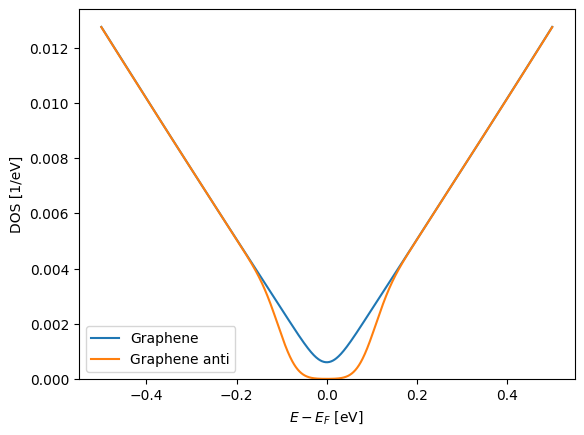

In [9]:
E = np.linspace(-0.5, 0.5, 1000)
dist = get_distribution('gaussian', 0.03)
bz.set_parent(H)
plt.plot(E, bz_average.DOS(E, distribution=dist), label='Graphene');
bz.set_parent(H_bp)
plt.plot(E, bz_average.DOS(E, distribution=dist), label='Graphene anti');
plt.legend()
plt.ylim([0, None])
plt.xlabel('$E - E_F$ [eV]');
plt.ylabel('DOS [1/eV]');

## Berry phase calculation

To calculate the Berry phase we are going to perform a discretized integration of the Bloch states on a closed loop. We are going to calculate it around the $K$-point with a given radius. After having created the 

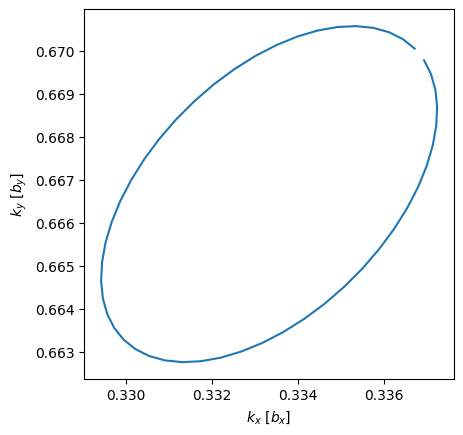

In [10]:
# Number of discretizations
N = 50
# Circle radius in 1/Ang
kR = 0.01
# Normal vector (in units of reciprocal lattice vectors)
normal = [0, 0, 1]
# Origo (in units of reciprocal lattice vectors)
origin = [1/3, 2/3, 0]
circle = BrillouinZone.param_circle(H, N, kR, normal, origin)
plt.plot(circle.k[:, 0], circle.k[:, 1]);
plt.xlabel(r'$k_x$ [$b_x$]')
plt.ylabel(r'$k_y$ [$b_y$]')
plt.gca().set_aspect('equal');

The above plot shows a skewed circle because the $k$-points in the Brillouin zone object is stored in units of reciprocal lattice vectors. I.e. the circle is perfect in the reciprocal space. Note that the below Berry phase calculation ensures the loop is completed by also taking into account the first and last point.

To confirm that the circle is *perfect* in reciprocal space, we convert the $k$-points and plot again. Note also that the radius of the circle is $0.01\mathrm{Ang}^{-1}$.

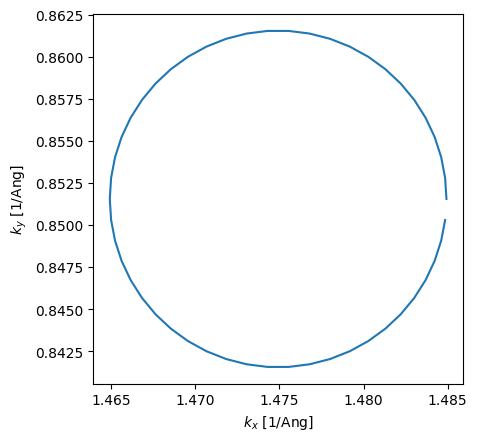

In [11]:
k = circle.tocartesian(circle.k)
plt.plot(k[:, 0], k[:, 1]);
plt.xlabel(r'$k_x$ [1/Ang]')
plt.ylabel(r'$k_y$ [1/Ang]')
plt.gca().set_aspect('equal');

Now we are ready to calculate the Berry phase. We calculate it for both graphene and the anti-symmetric graphene using only the first, second and both bands:

In [12]:
circle.set_parent(H)
print('Pristine graphene (0): {:.5f} rad'.format(electron.berry_phase(circle, sub=0)))
print('Pristine graphene (1): {:.5f} rad'.format(electron.berry_phase(circle, sub=1)))
print('Pristine graphene (:): {:.5f} rad'.format(electron.berry_phase(circle)))
circle.set_parent(H_bp)
print('Anti-symmetric graphene (0): {:.5f} rad'.format(electron.berry_phase(circle, sub=0)))
print('Anti-symmetric graphene (1): {:.5f} rad'.format(electron.berry_phase(circle, sub=1)))
print('Anti-symmetric graphene (:): {:.5f} rad'.format(electron.berry_phase(circle)))

Pristine graphene (0): 3.14159 rad
Pristine graphene (1): 3.14159 rad
Pristine graphene (:): 0.00000 rad
Anti-symmetric graphene (0): 0.41733 rad
Anti-symmetric graphene (1): -0.41733 rad
Anti-symmetric graphene (:): -0.00000 rad


We now plot the Berry phase as a function of integration radius with a somewhat constant discretization. In addition we calculate the Berry phase in the skewed circle in reciprocal space and perfectly circular in the units of the reciprocal lattice vectors. This enables a comparison of the integration path.

info:0: SislInfo: BrillouinZone.param_circle increased the number of circle points to 4.
info:0: SislInfo: BrillouinZone.param_circle increased the number of circle points to 4.
info:0: SislInfo: BrillouinZone.param_circle increased the number of circle points to 4.
info:0: SislInfo: BrillouinZone.param_circle increased the number of circle points to 4.
info:0: SislInfo: BrillouinZone.param_circle increased the number of circle points to 4.
info:0: SislInfo: BrillouinZone.param_circle increased the number of circle points to 4.
info:0: SislInfo: BrillouinZone.param_circle increased the number of circle points to 4.
info:0: SislInfo: BrillouinZone.param_circle increased the number of circle points to 4.


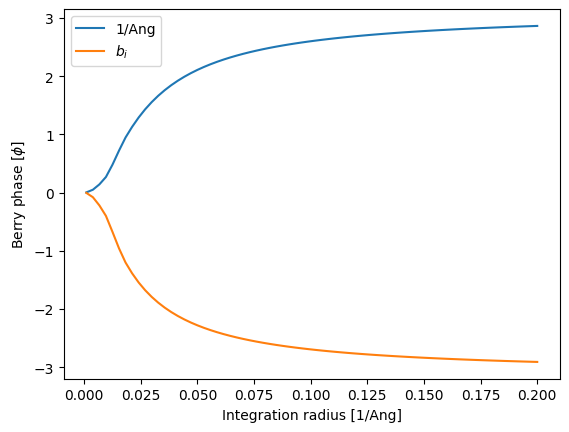

In [13]:
kRs = np.linspace(0.001, 0.2, 70)
dk = 0.0001
bp = np.empty([2, len(kRs)])
for i, kR in enumerate(kRs):
    circle = BrillouinZone.param_circle(H_bp, dk, kR, normal, origin)
    bp[0, i] = electron.berry_phase(circle, sub=0)
    circle_other = BrillouinZone.param_circle(utils.mathematics.fnorm(H_bp.rcell), dk, kR, normal, origin)
    circle.k[:, :] = circle_other.k[:, :]
    bp[1, i] = -electron.berry_phase(circle, sub=0)
plt.plot(kRs, bp[0, :], label=r'1/Ang');
plt.plot(kRs, bp[1, :], label=r'$b_i$');
plt.legend()
plt.xlabel(r'Integration radius [1/Ang]');
plt.ylabel(r'Berry phase [$\phi$]');